
--- Overall Performance Analysis ---
Overall Accuracy: 15.00%

Single model used: gpt-4.1-nano

Accuracy by Dataset:
dataset
MedQA    0.2
NEJM     0.1
Name: is_correct, dtype: float64

--- Test-Ordering Behavior Analysis ---

Mean proportion of tests left out: 95.00%
Median proportion of tests left out: 100.00%

Most Frequently Left-Out Tests (Overall):
- Skin biopsy: 2 times
- Blood_Tests: 2 times
- Imaging: 2 times
- Biopsy: 2 times
- Urinalysis: 2 times
- Dermoscopy: 1 times
- Tests for cryptococcus: 1 times
- Tests for human immunodeficiency virus (HIV): 1 times
- Tests for histoplasmosis: 1 times
- High-resolution computed tomography (CT) of the chest: 1 times

Most Frequently Left-Out Tests (in Incorrect Diagnoses):
- Skin biopsy: 2 times
- Biopsy: 2 times
- Urinalysis: 2 times
- Dermoscopy: 1 times
- Tests for cryptococcus: 1 times
- Tests for human immunodeficiency virus (HIV): 1 times
- Tests for histoplasmosis: 1 times
- High-resolution computed tomography (CT) of the chest:

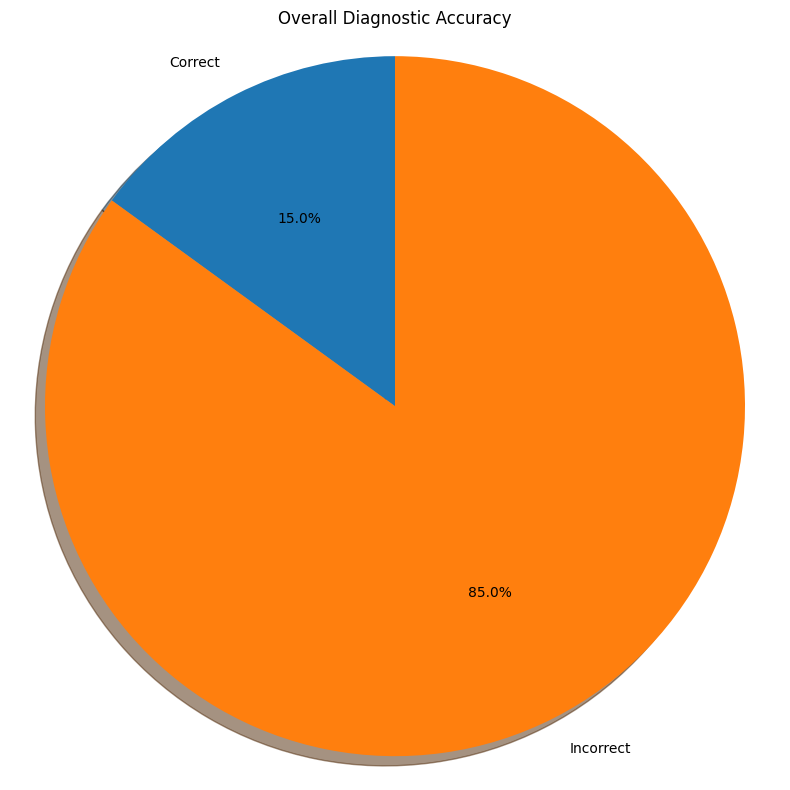

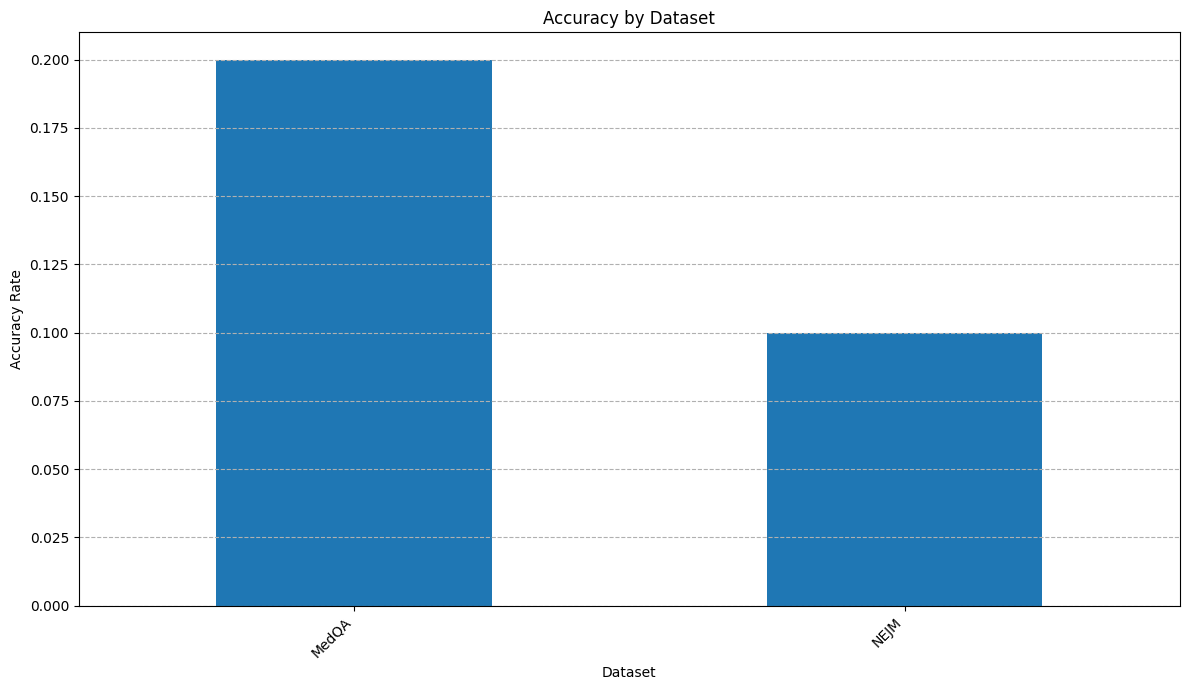

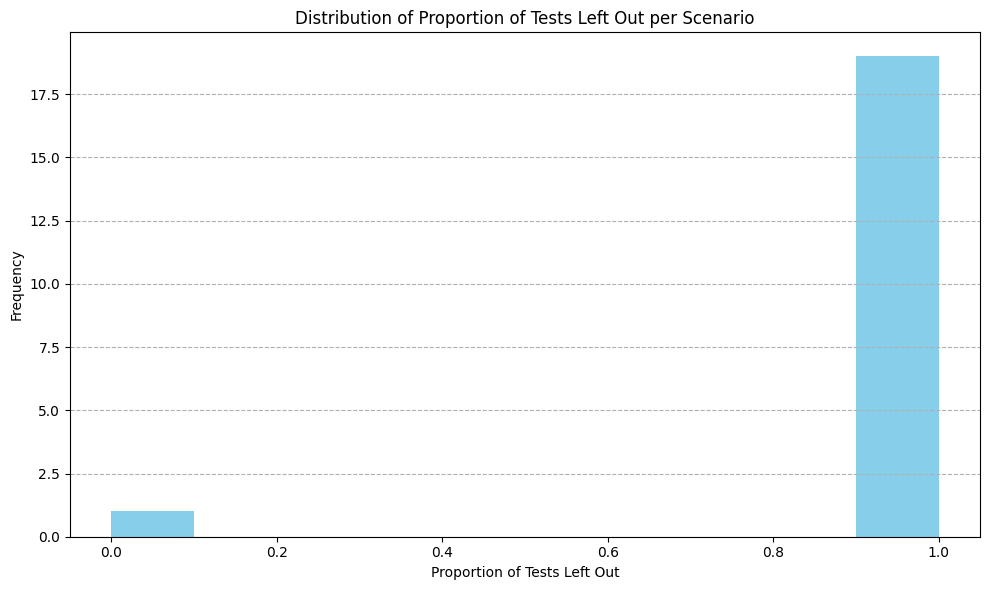

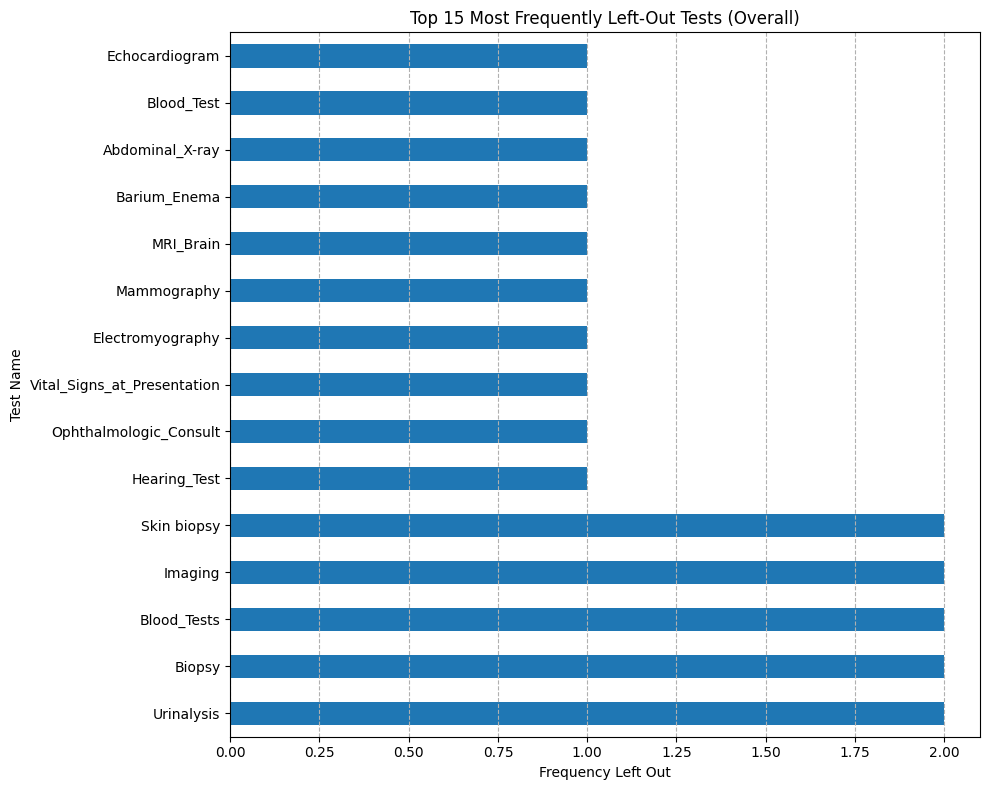

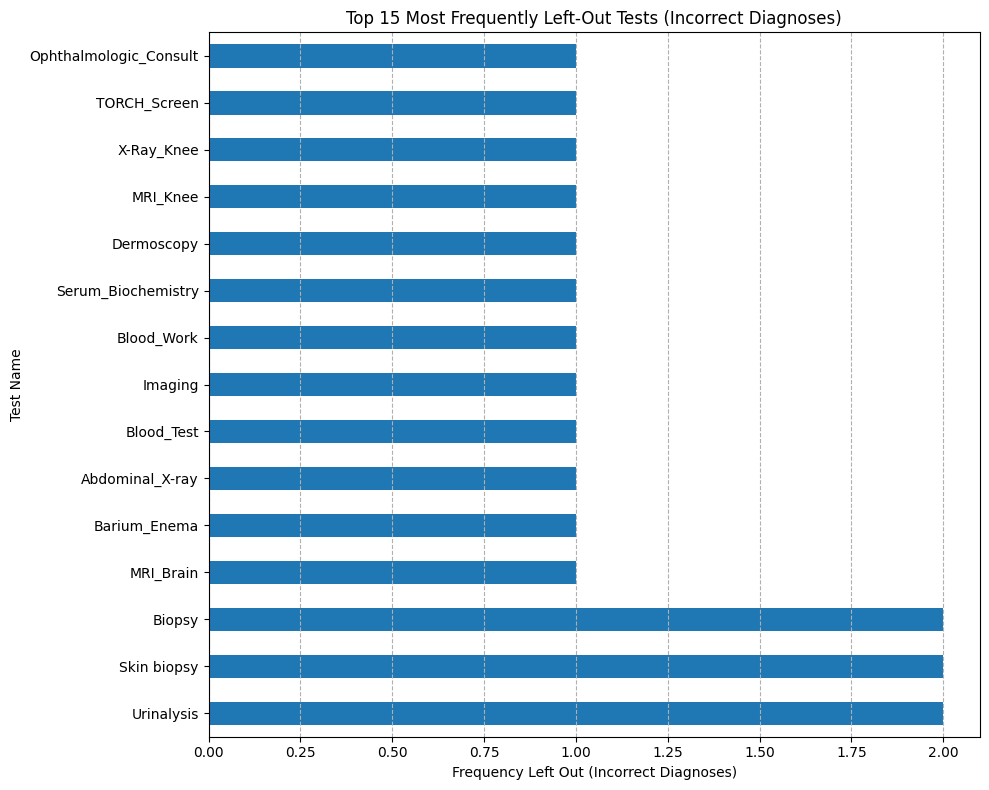

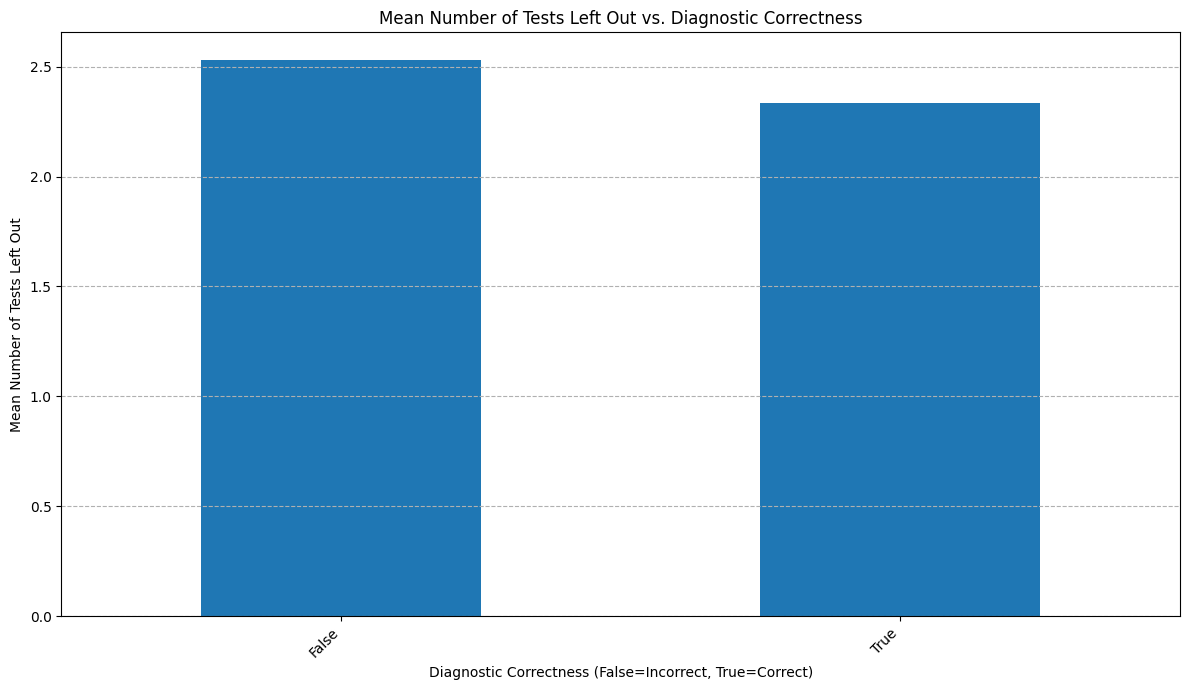

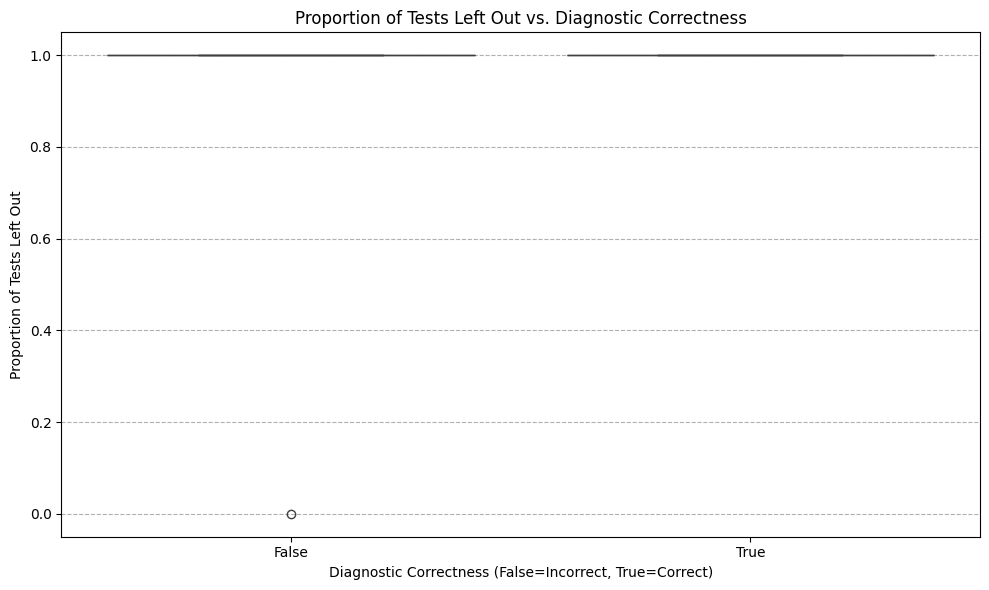

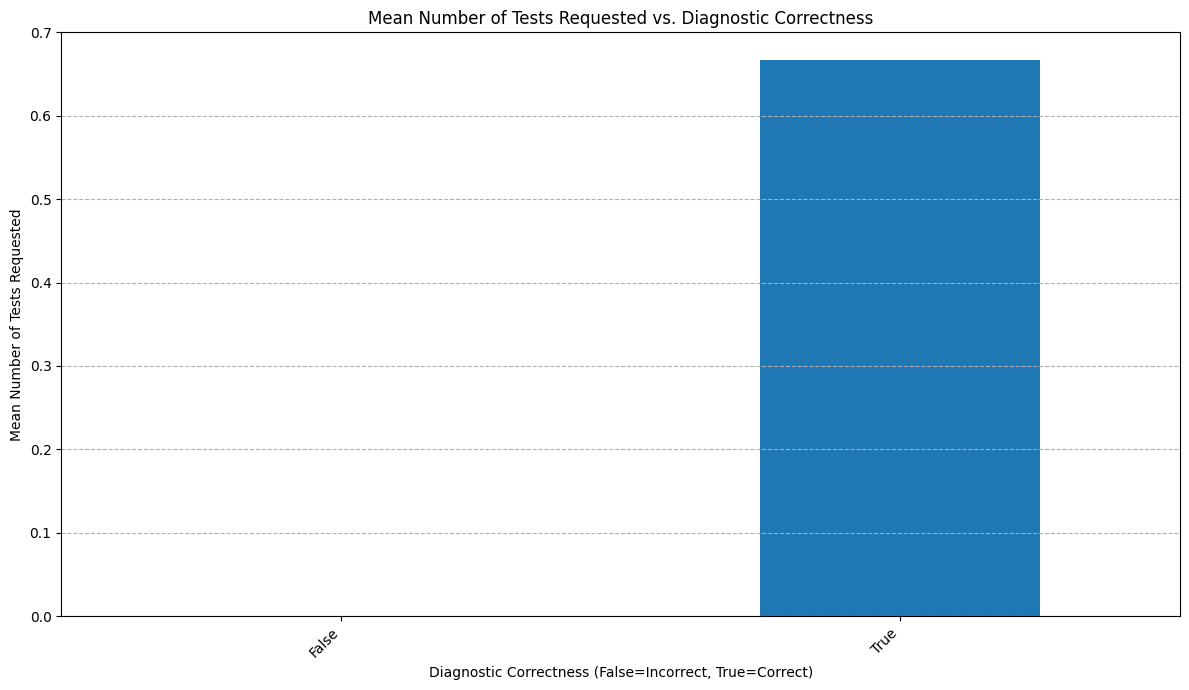

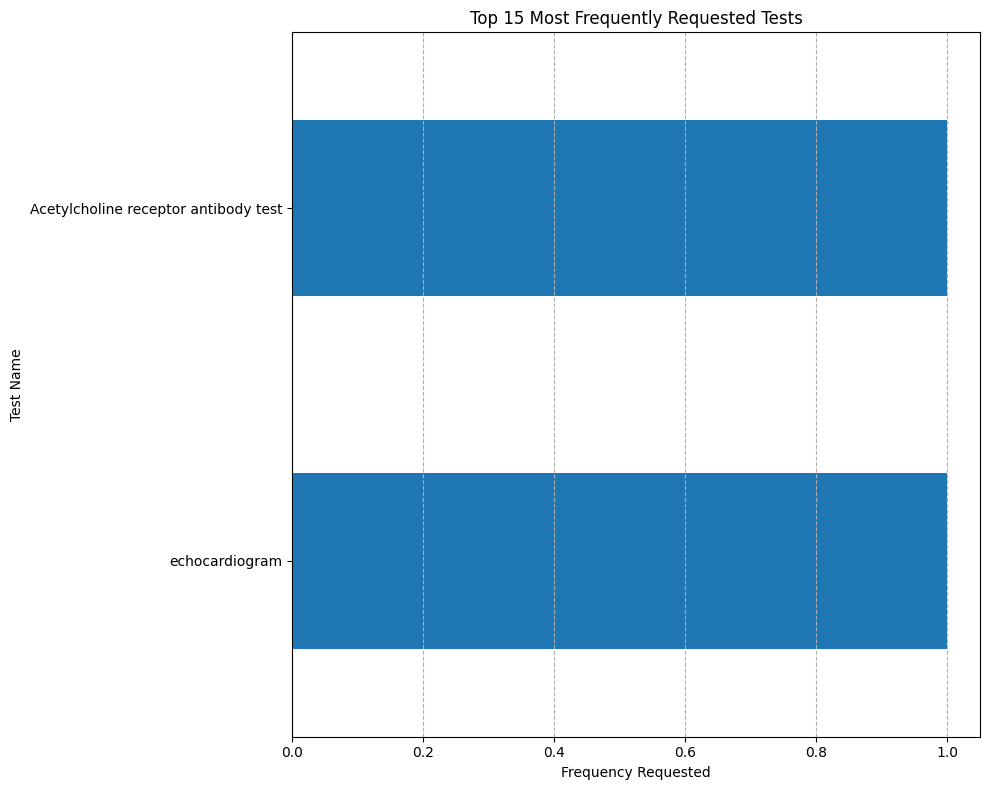

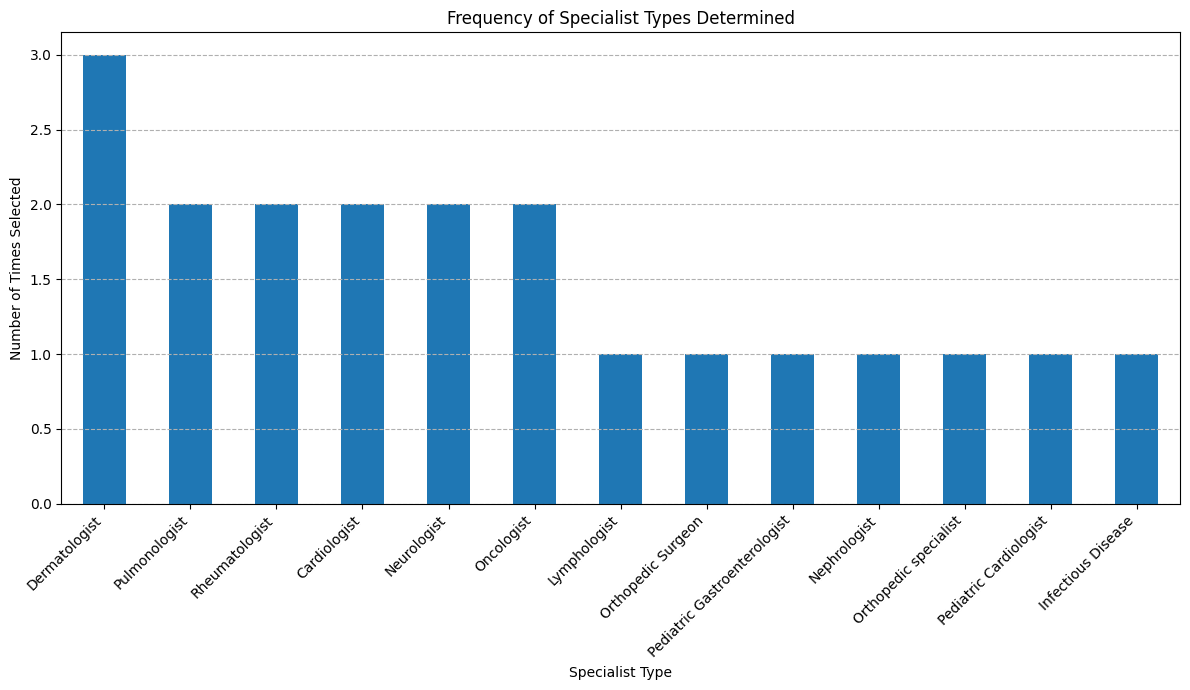

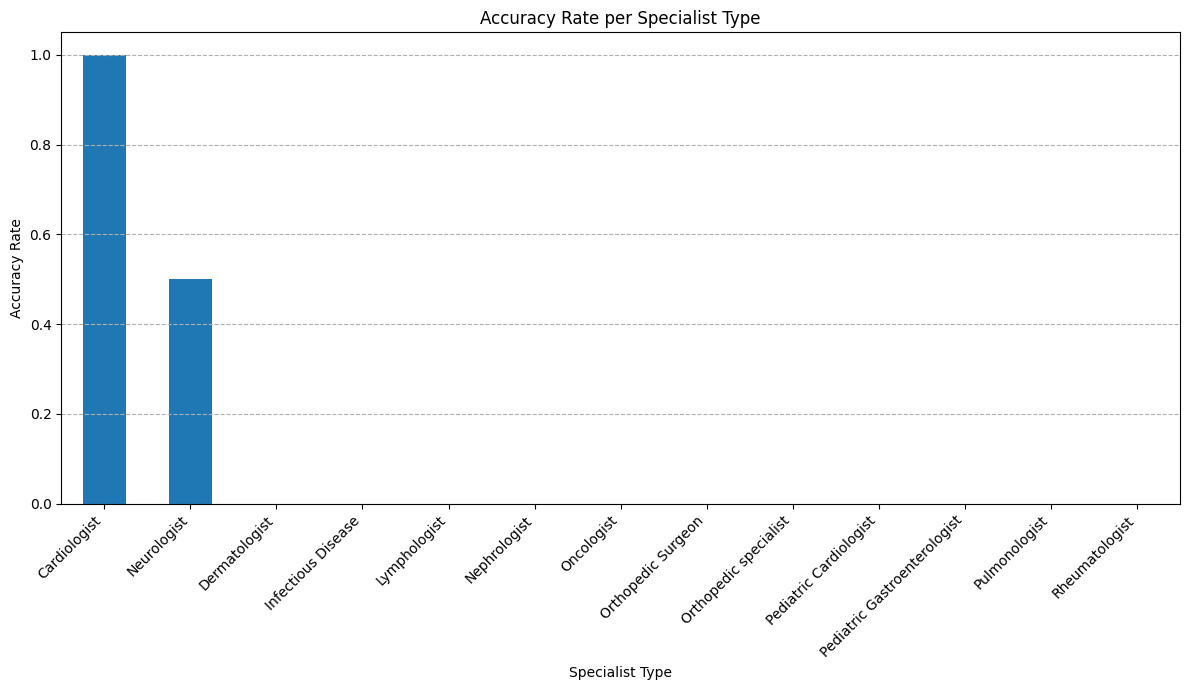

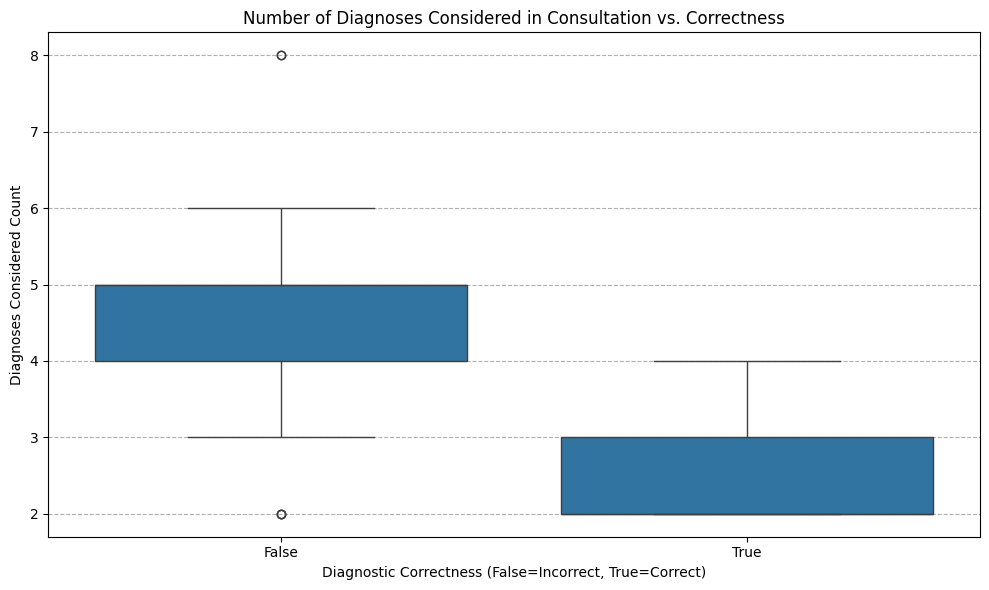

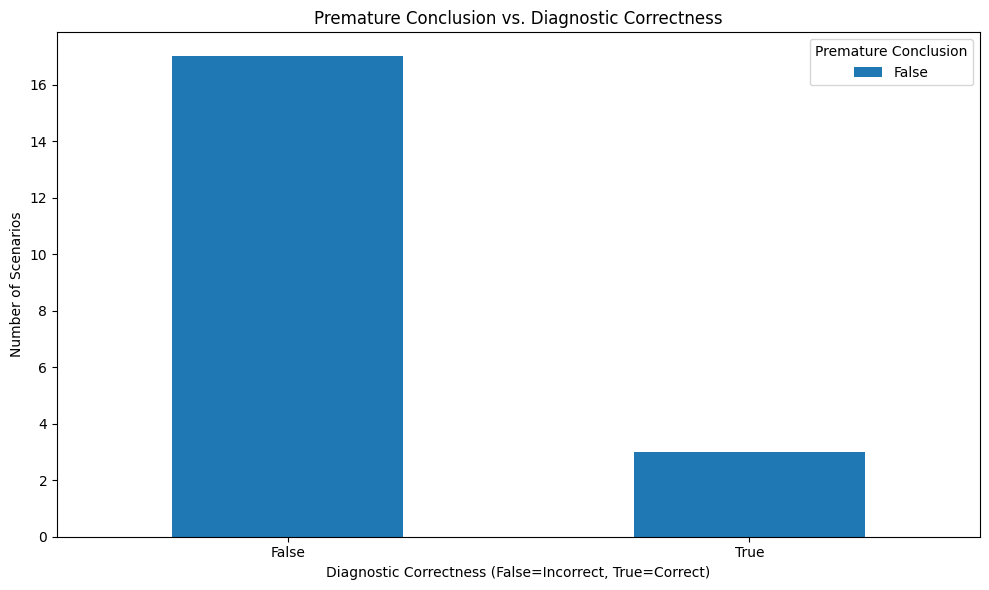

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Helper functions for plotting
def plot_bar_chart(data_series, title, xlabel, ylabel, rotation=45, figsize=(12, 7), color=None, is_horizontal=False):
    plt.figure(figsize=figsize)
    if is_horizontal: # Better for long labels on y-axis
        data_series.plot(kind='barh', color=color)
        plt.xlabel(ylabel) 
        plt.ylabel(xlabel) 
    else:
        data_series.plot(kind='bar', color=color)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=rotation, ha='right')
    plt.title(title)
    plt.grid(axis='x' if is_horizontal else 'y', linestyle='--')
    plt.tight_layout() # Adjust layout to prevent labels from overlapping

def plot_histogram(data_series, title, xlabel, ylabel, bins=10, figsize=(10, 6), color='skyblue'):
    plt.figure(figsize=figsize)
    data_series.plot(kind='hist', bins=bins, color=color, ec='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()

def plot_pie_chart(sizes, labels, title, figsize=(8, 8), autopct='%1.1f%%'):
    plt.figure(figsize=figsize)
    # Filter out zero sizes to prevent issues with pie chart rendering if a category has 0 count
    valid_indices = [i for i, size in enumerate(sizes) if size > 0]
    valid_sizes = [sizes[i] for i in valid_indices]
    valid_labels = [labels[i] for i in valid_indices]

    if not valid_sizes: 
        plt.text(0.5, 0.5, 'No data to display', ha='center', va='center', fontsize=12)
    else:
        plt.pie(valid_sizes, labels=valid_labels, autopct=autopct, startangle=90, shadow=True)
    
    plt.title(title)
    plt.axis('equal') 
    plt.tight_layout()

def plot_boxplot(df, x_col, y_col, title, xlabel, ylabel, figsize=(10,6)):
    plt.figure(figsize=figsize)
    sns.boxplot(x=x_col, y=y_col, data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()

# Function to load data from log.json
def load_data(filepath="log.json"):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Error: The file {filepath} was not found.")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: The file {filepath} is not a valid JSON. Details: {e}")
        return None

# 1. Overall Performance Analysis
def analyze_overall_performance(df):
    print("\n--- Overall Performance Analysis ---")
    if df.empty:
        print("DataFrame is empty. Skipping overall performance analysis.")
        return

    # Overall accuracy
    overall_accuracy = df['is_correct'].mean()
    print(f"Overall Accuracy: {overall_accuracy:.2%}")
    
    # Plot pie chart for accuracy
    # Ensure there's data to plot and handle cases where accuracy is 100% or 0%
    if not df['is_correct'].empty:
        correct_count = df['is_correct'].sum()
        incorrect_count = len(df) - correct_count
        plot_pie_chart([correct_count, incorrect_count], 
                       ['Correct', 'Incorrect'], 
                       'Overall Diagnostic Accuracy')
    else:
        print("No data for 'is_correct' to plot pie chart.")


    # Accuracy by model (if multiple models)
    if df['model'].nunique() > 1:
        accuracy_by_model = df.groupby('model')['is_correct'].mean().sort_values(ascending=False)
        print("\nAccuracy by Model:")
        print(accuracy_by_model)
        plot_bar_chart(accuracy_by_model, 'Accuracy by Model', 'Model', 'Accuracy Rate')
    elif not df.empty:
        print(f"\nSingle model used: {df['model'].unique()[0]}")

    # Accuracy by dataset (if multiple datasets)
    if df['dataset'].nunique() > 1:
        accuracy_by_dataset = df.groupby('dataset')['is_correct'].mean().sort_values(ascending=False)
        print("\nAccuracy by Dataset:")
        print(accuracy_by_dataset)
        plot_bar_chart(accuracy_by_dataset, 'Accuracy by Dataset', 'Dataset', 'Accuracy Rate')
    elif not df.empty:
        print(f"\nSingle dataset used: {df['dataset'].unique()[0]}")

# 2. Test-Ordering Behavior Analysis
def analyze_test_ordering(df):
    print("\n--- Test-Ordering Behavior Analysis ---")
    if df.empty:
        print("DataFrame is empty. Skipping test-ordering analysis.")
        return

    # Density of left-out tests
    print(f"\nMean proportion of tests left out: {df['proportion_tests_left_out'].mean():.2%}")
    print(f"Median proportion of tests left out: {df['proportion_tests_left_out'].median():.2%}")
    if not df['proportion_tests_left_out'].empty:
        plot_histogram(df['proportion_tests_left_out'][df['num_available_tests'] > 0], # Only plot for scenarios with available tests
                       'Distribution of Proportion of Tests Left Out per Scenario',
                       'Proportion of Tests Left Out', 'Frequency', bins=10)

    # Frequency and "Importance" of left-out tests
    all_left_out_tests = [test for sublist in df['tests_left_out'] for test in sublist if test != "No tests mentioned"]
    if all_left_out_tests:
        left_out_test_counts = Counter(all_left_out_tests)
        print("\nMost Frequently Left-Out Tests (Overall):")
        for test, count in left_out_test_counts.most_common(10):
            print(f"- {test}: {count} times")
        
        left_out_series = pd.Series(left_out_test_counts).sort_values(ascending=False)
        plot_bar_chart(left_out_series.head(15), 
                       'Top 15 Most Frequently Left-Out Tests (Overall)',
                       'Test Name', 'Frequency Left Out', is_horizontal=True, figsize=(10,8))

        # "Importance": Tests left out in incorrect diagnoses
        incorrect_scenarios_df = df[~df['is_correct']] # Using ~ for boolean negation
        if not incorrect_scenarios_df.empty:
            left_out_in_incorrect = [test for sublist in incorrect_scenarios_df['tests_left_out'] for test in sublist if test != "No tests mentioned"]
            if left_out_in_incorrect:
                left_out_in_incorrect_counts = Counter(left_out_in_incorrect)
                print("\nMost Frequently Left-Out Tests (in Incorrect Diagnoses):")
                for test, count in left_out_in_incorrect_counts.most_common(10):
                    print(f"- {test}: {count} times")
                
                incorrect_left_out_series = pd.Series(left_out_in_incorrect_counts).sort_values(ascending=False)
                plot_bar_chart(incorrect_left_out_series.head(15),
                               'Top 15 Most Frequently Left-Out Tests (Incorrect Diagnoses)',
                               'Test Name', 'Frequency Left Out (Incorrect Diagnoses)', is_horizontal=True, figsize=(10,8))
            else:
                print("\nNo specific tests were left out in scenarios with incorrect diagnoses.")
        else:
            print("\nNo incorrect diagnoses to analyze for left-out tests.")
    else:
        print("\nNo specific tests were left out in any scenario.")

    # Correlation with correctness
    if not df.empty:
        mean_left_out_by_correctness = df.groupby('is_correct')['num_tests_left_out'].mean()
        if not mean_left_out_by_correctness.empty:
            print("\nMean Number of Tests Left Out by Diagnostic Correctness:")
            print(mean_left_out_by_correctness)
            plot_bar_chart(mean_left_out_by_correctness,
                           'Mean Number of Tests Left Out vs. Diagnostic Correctness',
                           'Diagnostic Correctness (False=Incorrect, True=Correct)',
                           'Mean Number of Tests Left Out')

        if 'proportion_tests_left_out' in df.columns and not df['proportion_tests_left_out'].empty:
             plot_boxplot(df, 'is_correct', 'proportion_tests_left_out',
                         'Proportion of Tests Left Out vs. Diagnostic Correctness',
                         'Diagnostic Correctness (False=Incorrect, True=Correct)',
                         'Proportion of Tests Left Out')
        
        # Analysis of tests_requested_count
        df['tests_requested_count_numeric'] = pd.to_numeric(df['tests_requested_count'], errors='coerce').fillna(0)
        if df['tests_requested_count_numeric'].sum() > 0: # only if some tests were requested
            mean_requested_by_correctness = df.groupby('is_correct')['tests_requested_count_numeric'].mean()
            print("\nMean Number of Tests Requested by Diagnostic Correctness:")
            print(mean_requested_by_correctness)
            plot_bar_chart(mean_requested_by_correctness,
                           'Mean Number of Tests Requested vs. Diagnostic Correctness',
                           'Diagnostic Correctness (False=Incorrect, True=Correct)',
                           'Mean Number of Tests Requested')

    # Analysis of Requested Tests (specific tests)
    df['actual_tests_requested_list'] = df['requested_tests'].apply(
        lambda x: [item.strip("[]") for item in x] if isinstance(x, list) else []
    )
    all_requested_tests = [test for sublist in df['actual_tests_requested_list'] for test in sublist if test] # Ensure non-empty strings
    
    if all_requested_tests:
        requested_test_counts = Counter(all_requested_tests)
        print("\nMost Frequently Requested Tests by Doctor Model:")
        for test, count in requested_test_counts.most_common(10):
            print(f"- {test}: {count} times")
        
        requested_series = pd.Series(requested_test_counts).sort_values(ascending=False)
        plot_bar_chart(requested_series.head(15),
                       'Top 15 Most Frequently Requested Tests',
                       'Test Name', 'Frequency Requested', is_horizontal=True, figsize=(10,8))
    else:
        print("\nNo tests were explicitly requested by the doctor model, or 'requested_tests' field was empty/malformed.")

    # Compare requested tests vs available tests
    requested_scenarios = df[df['tests_requested_count_numeric'] > 0]
    if not requested_scenarios.empty:
        print("\nAnalysis of Requested Tests vs. Available Tests:")
        mismatch_count = 0
        for _, row in requested_scenarios.iterrows():
            requested = set(row['actual_tests_requested_list'])
            available = set(row['available_tests'])
            if not requested.issubset(available):
                print(f"  Scenario {row['scenario_id']}: Requested tests {requested - available} not in available tests {available}.")
                mismatch_count +=1
        if mismatch_count == 0:
            print("  In all scenarios with requested tests, the requested tests were part of the available tests (or no such mismatches found).")

# 3. Specialist Selection Investigation
def analyze_specialist_selection(df, raw_data_list):
    print("\n--- Specialist Selection Investigation ---")
    if df.empty:
        print("DataFrame is empty. Skipping specialist selection analysis.")
        return
    
    # Use .copy() to avoid SettingWithCopyWarning when filtering
    df_specialists = df[df['determined_specialist'].notna() & (df['determined_specialist'] != '')].copy()
    if df_specialists.empty:
        print("No specialist information found or all specialist fields are empty.")
        return

    # Frequency of specialists
    specialist_counts = df_specialists['determined_specialist'].value_counts()
    print("\nFrequency of Each Specialist Type Determined:")
    print(specialist_counts)
    if not specialist_counts.empty:
        plot_bar_chart(specialist_counts, 'Frequency of Specialist Types Determined', 
                       'Specialist Type', 'Number of Times Selected')

    # Accuracy per specialist
    accuracy_per_specialist = df_specialists.groupby('determined_specialist')['is_correct'].mean().sort_values(ascending=False)
    print("\nAccuracy Rate per Specialist Type:")
    print(accuracy_per_specialist)
    if not accuracy_per_specialist.empty:
        plot_bar_chart(accuracy_per_specialist, 'Accuracy Rate per Specialist Type',
                       'Specialist Type', 'Accuracy Rate')

    # Qualitative examples
    print("\nQualitative Examples of Specialist Selection:")
    sample_size = min(5, len(raw_data_list)) # Show up to 5 examples
    for i in range(sample_size):
        scenario = raw_data_list[i]
        # Safely get values from the scenario dictionary
        scenario_id = scenario.get('scenario_id', 'N/A')
        determined_specialist = scenario.get('determined_specialist', 'N/A')
        correct_diagnosis = scenario.get('correct_diagnosis', 'N/A')
        is_correct_val = scenario.get('is_correct', 'N/A')
        dialogue_history = scenario.get('dialogue_history', [])
        
        initial_complaint = "N/A"
        if dialogue_history:
            # Find first patient utterance
            for turn_info in dialogue_history:
                if turn_info.get('speaker') == 'Patient' and turn_info.get('phase') == 'patient':
                    initial_complaint = turn_info.get('text', 'N/A')
                    break
        
        print(f"\n  Scenario ID: {scenario_id}")
        print(f"  Initial Patient Complaint: {initial_complaint[:100]}{'...' if len(initial_complaint)>100 else ''}") # Truncate for brevity
        print(f"  Determined Specialist: {determined_specialist}")
        print(f"  Correct Diagnosis for Scenario: {correct_diagnosis}")
        print(f"  Model's Diagnosis Correct: {is_correct_val}")

    # Look for doctor's reasoning (if any) before consultation starts
    print("\nDoctor's Reasoning for Specialist Consultation (if explicitly stated before system call):")
    found_reasoning_count = 0
    for scenario_data in raw_data_list:
        dialogue = scenario_data.get('dialogue_history', [])
        determined_specialist = scenario_data.get('determined_specialist')
        if not determined_specialist: # Skip if no specialist determined for this scenario
            continue

        consult_turn_index = -1
        # Find the system message indicating consultation start
        for idx, turn_data in enumerate(dialogue):
            if turn_data.get('speaker') == "System" and "Consultation started with" in turn_data.get('text', ""):
                consult_turn_index = idx
                break
        
        # Check the doctor's turn immediately preceding the system message
        if consult_turn_index > 0 and consult_turn_index < len(dialogue): # Ensure valid index
            prev_turn = dialogue[consult_turn_index - 1]
            if prev_turn.get('speaker') == "Doctor" and prev_turn.get('phase') == "patient": # Must be Doctor's turn in patient phase
                text_before_consult = prev_turn.get('text', "")
                # Basic keyword check for explicit reasoning.
                if "consult" in text_before_consult.lower() and determined_specialist.lower() in text_before_consult.lower():
                    print(f"  Scenario {scenario_data.get('scenario_id')}: Doctor mentioned consulting {determined_specialist}. Pre-consult text: \"{text_before_consult[:150]}{'...' if len(text_before_consult)>150 else ''}\"")
                    found_reasoning_count += 1
                elif "specialist" in text_before_consult.lower() and len(text_before_consult) > 80: # A more generic mention
                     print(f"  Scenario {scenario_data.get('scenario_id')}: Doctor mentioned consulting a specialist (determined: {determined_specialist}). Pre-consult text: \"{text_before_consult[:150]}{'...' if len(text_before_consult)>150 else ''}\"")
                     found_reasoning_count += 1

    if found_reasoning_count == 0:
        print("  No explicit reasoning for specific specialist choices found in Doctor's dialogue immediately before consultation system message for any scenario.")

# 4. Consultation Metrics Analysis
def analyze_consultation_metrics(df):
    print("\n--- Consultation Metrics Analysis ---")
    if df.empty:
        print("DataFrame is empty. Skipping consultation metrics analysis.")
        return

    # diagnoses_considered_count vs correctness
    if 'consultation_diagnoses_considered_count' in df.columns and df['consultation_diagnoses_considered_count'].sum() > 0:
        plot_boxplot(df, 'is_correct', 'consultation_diagnoses_considered_count',
                     'Number of Diagnoses Considered in Consultation vs. Correctness',
                     'Diagnostic Correctness (False=Incorrect, True=Correct)',
                     'Diagnoses Considered Count')
        print("\nMean Diagnoses Considered Count by Correctness:")
        print(df.groupby('is_correct')['consultation_diagnoses_considered_count'].mean())
    else:
        print("\n'consultation_diagnoses_considered_count' not available or all zero.")

    # premature_conclusion vs correctness
    if 'consultation_premature_conclusion' in df.columns:
        # Ensure boolean type for grouping
        df['consultation_premature_conclusion_bool'] = df['consultation_premature_conclusion'].astype(bool)
        premature_counts = df.groupby(['is_correct', 'consultation_premature_conclusion_bool']).size().unstack(fill_value=0)
        print("\nPremature Conclusion in Consultation vs. Correctness:")
        print(premature_counts)
        if not premature_counts.empty:
             premature_counts.plot(kind='bar', stacked=False, figsize=(10,6))
             plt.title('Premature Conclusion vs. Diagnostic Correctness')
             plt.xlabel('Diagnostic Correctness (False=Incorrect, True=Correct)')
             plt.ylabel('Number of Scenarios')
             plt.xticks(rotation=0)
             plt.legend(title='Premature Conclusion')
             plt.tight_layout()
    else:
        print("\n'consultation_premature_conclusion' not available.")
    
    # disagreements vs correctness
    if 'consultation_disagreements' in df.columns and df['consultation_disagreements'].sum() > 0 :
        plot_boxplot(df, 'is_correct', 'consultation_disagreements',
                     'Number of Disagreements in Consultation vs. Correctness',
                     'Diagnostic Correctness (False=Incorrect, True=Correct)',
                     'Number of Disagreements')
        print("\nMean Number of Disagreements by Correctness:")
        print(df.groupby('is_correct')['consultation_disagreements'].mean())
    else:
        print("\n'consultation_disagreements' not available or all zero.")

# Main script execution
def main():
    raw_data_list = load_data("log.json") # Assuming log.json is in the same directory
    if raw_data_list is None:
        print("Failed to load data. Exiting.")
        return

    df = pd.DataFrame(raw_data_list)

    if df.empty:
        print("Loaded data is empty or could not be converted to DataFrame. Exiting.")
        return

    # Preprocessing and feature engineering
    df['num_available_tests'] = df['available_tests'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    
    # Function to count actual tests, excluding "No tests mentioned" placeholder
    def count_actual_tests(tests_list):
        if isinstance(tests_list, list):
            if tests_list == ["No tests mentioned"]: # If the list solely contains this placeholder
                return 0
            return len([test for test in tests_list if test != "No tests mentioned"]) # Count specific tests
        return 0
    df['num_tests_left_out'] = df['tests_left_out'].apply(count_actual_tests)
    
    # Calculate proportion of tests left out, handling division by zero
    df['proportion_tests_left_out'] = df.apply(
        lambda row: (row['num_tests_left_out'] / row['num_available_tests']) if row['num_available_tests'] > 0 else 0,
        axis=1
    )
    
    # Safely extract consultation analysis fields
    df['consultation_analysis'] = df['consultation_analysis'].apply(lambda x: x if isinstance(x, dict) else {}) # Ensure it's a dict
    df['consultation_diagnoses_considered_count'] = df['consultation_analysis'].apply(lambda x: x.get('diagnoses_considered_count', 0))
    df['consultation_premature_conclusion'] = df['consultation_analysis'].apply(lambda x: x.get('premature_conclusion', False))
    df['consultation_disagreements'] = df['consultation_analysis'].apply(lambda x: x.get('disagreements', 0))

    # Ensure 'is_correct' is boolean
    df['is_correct'] = df['is_correct'].astype(bool)

    # Run analyses
    analyze_overall_performance(df)
    analyze_test_ordering(df)
    analyze_specialist_selection(df, raw_data_list) # Pass raw_data_list for dialogue access
    analyze_consultation_metrics(df)
    
    print("\n--- Analysis Complete ---")
    print("Displaying all generated plots. Please close plot windows to terminate the script.")
    plt.show() # Display all plots at the end

if __name__ == "__main__":
    main()